connTask is a package used for the prediction of task evoked patterns of activity (derived from tFMRI data) using functional connectivity data

it is based on the work by Tavor et al (2016) https://science.sciencemag.org/content/352/6282/216

install: "pip install conntask_ni"

In [20]:
from conntask_ni import utils, extract_features, model_and_predict
import nibabel as nb
import numpy as np
import seaborn as sns

the first step is to extract functional connectivity features from the raw data (usually rsfMRI, couls be also naturalistic-stimuli fMRI or even tFMRI time-series data)

to do so, we use a set of spatially individual components, derived from a group ica procedure, to define define a set of networks that will be the basis of our feature set.

in this example, we use a set of 43 components dervied from the data of 100 HCP participants

In [5]:
cifti = nb.load('test_files/test_feature_extract/ica_both_hemis_45_comp_cleaned.dtseries.nii') # i keep t
ica = np.asarray(cifti.get_fdata())

next, we go over all participants in our data set and perform the 2 steps of the feature extraction procedure:

1) dual regression of group ica components, to yield participant-specific representation of the group-ica

2) a weighted seed2voxel procedure on the the components from the previous step

In [8]:
# set an outpurt directory for the features
outdir = '/Volumes/homes/Shachar/connTask_py_test/features'
# set origin directory for raw data
data_dir = '/Volumes/IT_RawData/HCP/rfMRI'

# iterate through all participants and perform feature extraction
subjlist = '/Volumes/homes/Shachar/connTask_py_test/subjects.txt'
with open(subjlist) as f:
    subjects = [s.strip('\n') for s in f.readlines()]

for i, sub in enumerate(subjects):
    rs_dir = f'{data_dir}/{sub}/MNINonLinear/Results'
    print(f'subject {i+1}/{len(subjects)}: {sub}')
    
    # read data from all 4 runs of the hcp-data. 
    # read_multiple_ts_data() normalizes, demeans, detrends, and concatenates
    # the data from the different runs
    rs_paths = [f'{rs_dir}/{scan}/{scan}_Atlas_MSMAll_hp2000_clean.dtseries.nii' for scan in os.listdir(rs_dir)]
    data = utils.read_multiple_ts_data(rs_paths)

    # perform the two steps of feature-extraction
    print('extracting features')
    dr_comps = extract_features.dual_regression(data, ica)
    features = extract_features.weighted_seed2voxel(dr_comps, data)
    
    # save to outdir
    print('saving features')
    to_save = nb.cifti2.cifti2.Cifti2Image(features.T, header=cifti.header)
    nb.save(to_save, f'{outdir}/{sub}_features_43_comps.dtseries.nii')


the features extracted above can now be used to model the relationship between functionall connectivity and task-evoked patterns of brain activity.

now we need some kind of target measure to predict. in this example we will use the 2bk contrast from the HCP's Working Memory task:

In [9]:
# we assume data is organized as such target_data_dir/participant_id/path_to_file
# we read all the data and concatenate to yield a participants-X-vertices matrix
# data could be saved as pickle or dtseries.nii; could also not be saved if no "out_path" provided 
target_data_dir = '/Volumes/IT_RawData/HCP/tfMRI/WM'
path_to_file = 'MNINonLinear/Results/tfMRI_WM/tfMRI_WM_hp200_s4_level2_MSMAll.feat/GrayordinatesStats/cope9.feat/zstat1.dtseries.nii'
target = utils.make_multi_subject_maps_obj(subjlist=subjlist, data_dir=target_data_dir,path_to_file=path_to_file,
                                           out_path='/Volumes/homes/Shachar/connTask_py_test/wm_09_target.pickle')

# read in all subject's features to one 3d-matrix (vertices-X-participants-X-feature_number)
# this could take a while, as it's a large amount of data...
features = utils.read_all_features(subjlist=subjlist, data_dir= outdir, path_to_file='features_43_comps.dtseries.nii')


a few more things to define, and we'll be ready to start modelling:
1) our procedure uses a parcellation of the brain in order to multiple several models, each for a defined brain area. here we a 100 nodes parcellation that is based on the division of the human cortex to 7 distinct connectivity networks (Schaefer et al., 2018; Thomas Yeo et al., 2011)

2) the object we will use here employs a cross validation procedure. thus, we need to define the number of splits we wish to use. here we opt for a LOO, so n_splits == n == 100.

3) define the type of sklearn object we wish to use as a model. this is passed using a keyword dict. current options are GLM and ElasticNetCV. here we use a simple GLM

In [ ]:
# set needed parameters
parcellation = utils.read_data('src/conntask_ni/files/Schaefer2018_100Parcels_7Networks_order.dtseries.nii')
model_kws = {'type': 'glm'}
n_splits = 100

# form the connTaskCV object
cv_predict = model_and_predict.ConnTaskCV(features=features, target=target, parcellation=parcellation,
                                          model_kws=model_kws, normalise_features=True, n_splits=n_splits)
# model and predict using CV
cv_predict.predict_CV()

normalising features...
-----fold 1-----
fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26/100...
27/100...
28/100...
29/100...
30/100...
31/100...
32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50/100...
51/100...
52/100...
53/100...
54/100...
55/100...
56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75/100...
76/100...
77/100...
78/100...
79/100...
80/100...
81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/

77/100...
78/100...
79/100...
80/100...
81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/100...
100/100...
predicting test set...
-----fold 9-----
fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26/100...
27/100...
28/100...
29/100...
30/100...
31/100...
32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50/100...
51/100...
52/100...
53/100...
54/100...
55/100...
56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/

52/100...
53/100...
54/100...
55/100...
56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75/100...
76/100...
77/100...
78/100...
79/100...
80/100...
81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/100...
100/100...
predicting test set...
-----fold 17-----
fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26/100...
27/100...
28/100...
29/100...
30/100...
31/100...
32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46

26/100...
27/100...
28/100...
29/100...
30/100...
31/100...
32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50/100...
51/100...
52/100...
53/100...
54/100...
55/100...
56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75/100...
76/100...
77/100...
78/100...
79/100...
80/100...
81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/100...
100/100...
predicting test set...
-----fold 25-----
fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20

fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26/100...
27/100...
28/100...
29/100...
30/100...
31/100...
32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50/100...
51/100...
52/100...
53/100...
54/100...
55/100...
56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75/100...
76/100...
77/100...
78/100...
79/100...
80/100...
81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/1

81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/100...
100/100...
predicting test set...
-----fold 40-----
fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26/100...
27/100...
28/100...
29/100...
30/100...
31/100...
32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50/100...
51/100...
52/100...
53/100...
54/100...
55/100...
56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75

56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75/100...
76/100...
77/100...
78/100...
79/100...
80/100...
81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/100...
100/100...
predicting test set...
-----fold 48-----
fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26/100...
27/100...
28/100...
29/100...
30/100...
31/100...
32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50

32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50/100...
51/100...
52/100...
53/100...
54/100...
55/100...
56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75/100...
76/100...
77/100...
78/100...
79/100...
80/100...
81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/100...
100/100...
predicting test set...
-----fold 56-----
fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26

7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26/100...
27/100...
28/100...
29/100...
30/100...
31/100...
32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50/100...
51/100...
52/100...
53/100...
54/100...
55/100...
56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75/100...
76/100...
77/100...
78/100...
79/100...
80/100...
81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/100...
100/100...
predicting test set...
-----fold 64-----
fitting model per par

87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/100...
100/100...
predicting test set...
-----fold 71-----
fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26/100...
27/100...
28/100...
29/100...
30/100...
31/100...
32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50/100...
51/100...
52/100...
53/100...
54/100...
55/100...
56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75/100...
76/100...
77/100...
78/100...
79/100...
80/100...
81

60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75/100...
76/100...
77/100...
78/100...
79/100...
80/100...
81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/100...
100/100...
predicting test set...
-----fold 79-----
fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26/100...
27/100...
28/100...
29/100...
30/100...
31/100...
32/100...
33/100...
34/100...
35/100...
36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50/100...
51/100...
52/100...
53/100...
54

36/100...
37/100...
38/100...
39/100...
40/100...
41/100...
42/100...
43/100...
44/100...
45/100...
46/100...
47/100...
48/100...
49/100...
50/100...
51/100...
52/100...
53/100...
54/100...
55/100...
56/100...
57/100...
58/100...
59/100...
60/100...
61/100...
62/100...
63/100...
64/100...
65/100...
66/100...
67/100...
68/100...
69/100...
70/100...
71/100...
72/100...
73/100...
74/100...
75/100...
76/100...
77/100...
78/100...
79/100...
80/100...
81/100...
82/100...
83/100...
84/100...
85/100...
86/100...
87/100...
88/100...
89/100...
90/100...
91/100...
92/100...
93/100...
94/100...
95/100...
96/100...
97/100...
98/100...
99/100...
100/100...
predicting test set...
-----fold 87-----
fitting model per parcel
1/100...
2/100...
3/100...
4/100...
5/100...
6/100...
7/100...
8/100...
9/100...
10/100...
11/100...
12/100...
13/100...
14/100...
15/100...
16/100...
17/100...
18/100...
19/100...
20/100...
21/100...
22/100...
23/100...
24/100...
25/100...
26/100...
27/100...
28/100...
29/100...
30

now all that is left is to evaluate our predictions.
to do so, we correlate the resulting connTask maps to the original activation maps, and yield to main measurements:
1) Diagonal mean: the mean correlation across participants between real and predicted activation maps from the same participant. this is a measure of the prediction’s accuracy.

2) Diagonality index: the difference between the diagonal mean and the off-diagonal mean. The off-diagonal mean represents the similarity of predicted map to real maps of all the other participants. this is a measure of the prediction’s specificity.

In [13]:
# as we only performed prediction in areas included in the parcellation
# we shall only examine prediction sucess in these areas
mask = (parcellation>0).flatten()

diag, off_diag, CM = utils.eval_pred_success(cv_predict.pred_maps, cv_predict.target, mask)

print(f'diagonal mean: {diag.mean()}')
print(f'diagonlity index: {diag.mean() - off_diag.mean()}')


diagonal mean: 0.7484708116926998
diagonlity index: 0.11231582724458744


<AxesSubplot:>

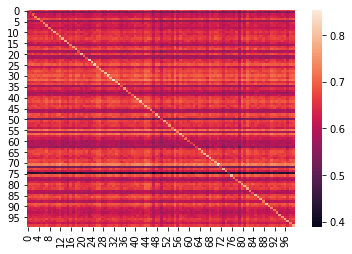

In [16]:
sns.heatmap(CM)